# Statistical Modelling

- I will use a hierarchical bayesian linear model like Twieki uses here: https://github.com/github/covid19-dashboard/blob/master/_notebooks/2020-03-16-covid19_growth_bayes.ipynb 

In [17]:
import theano

In [18]:
theano.config.device

'cpu'

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pymc3 as pm
import arviz as az

In [20]:
sns.set_style('whitegrid')

In [21]:
## load the data
df_cases = pd.read_pickle('./corona_scotland_regions_ts.pk')
df_total = pd.read_pickle('./corona_scotland_total_stats.pk')

In [22]:
max_num_days = len(df_cases)
max_num_days

37

In [23]:
## remove cases where there are hardly any cases
drop_cols = df_cases.columns[df_cases.quantile(0.5) == 0.0]
print(drop_cols)

df_cases = df_cases.drop(columns=drop_cols)

Index(['Eileanan Siar (Western Isles)', 'Orkney'], dtype='object', name='Health Board')


In [24]:
regions = df_cases.columns.values[:-1]
n_regions = len(regions)

In [25]:
np.argwhere(df_cases[regions[0]].gt(10).values).ravel()[0]

13

In [26]:
## find starting days
min_cases = 10
starting_days = {r: np.argwhere(df_cases[r].ge(min_cases).values).ravel()[0] for r in regions}
starting_days

{'Ayrshire and Arran': 13,
 'Borders': 15,
 'Dumfries and Galloway': 14,
 'Fife': 14,
 'Forth Valley': 9,
 'Grampian': 7,
 'Greater Glasgow and Clyde': 6,
 'Highland': 17,
 'Lanarkshire': 8,
 'Lothian': 6,
 'Shetland': 8,
 'Tayside': 8}

### Whole of Scotland

(0.0, 20000.0)

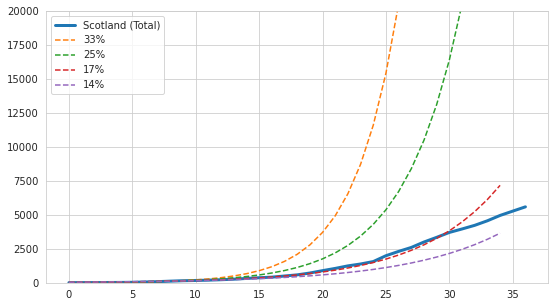

In [27]:
i = 8
c = df_cases['Scotland (Total)'].iloc[i]
df_cases['Scotland (Total)'].reset_index(drop=True)[:].plot(figsize=(9, 5), linewidth=3)
plt.plot(c*(1 + 0.33) ** (np.arange(0, 35, 1)-i), linestyle='--', label='33%')
plt.plot(c*(1 + 0.25) ** (np.arange(0, 35, 1)-i), linestyle='--', label='25%')
plt.plot(c*(1 + 0.17) ** (np.arange(0, 35, 1)-i), linestyle='--', label='17%')
plt.plot(c*(1 + 0.14) ** (np.arange(0, 35, 1)-i), linestyle='--', label='14%')
plt.legend()
plt.ylim(0, 20000)

In [28]:
with pm.Model() as model_scotland:
    
    ### Intercepts ###
    b = pm.Normal('b', 10, 5)
    
    
    ### Slopes ###
    a = pm.Normal('a', 1.18, 0.5)
    
    ### Error ###
    sigma = pm.HalfCauchy('sigma', 50.)
    
    ### Likelihood for Each Region ###
    cases = df_cases['Scotland (Total)'].values[10:]
        
    # From Twieki:
    # By using pm.Data we can change these values after sampling.
    # This allows us to extend x into the future so we can get
    # forecasts by sampling from the posterior predictive
    x = pm.Data('x_data',
                np.arange(10, max_num_days, 1))
    confirmed = pm.Data('y_data',
                        cases)

    # Likelihood
    pm.NegativeBinomial(
        'Scotland (Total)',
        (b * a ** (x-8)), # Exponential regression
        sigma,
        observed=confirmed)

In [29]:
with model_scotland:
    # Sample posterior
    trace_scotland = pm.sample(tune=1000, draws=2000, 
                               chains=2, cores=4, target_accept=0.9,
                               )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, a, b]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [00:15<00:00, 381.30draws/s]


In [30]:
with model_scotland:
    # Update data so that we get predictions into the future
    x_data = np.arange(0, 40)
    y_data = np.array([np.nan] * len(x_data))
    pm.set_data({'x_data': x_data})
    pm.set_data({'y_data': y_data})
        
    # sample posterior predictive
    post_pred = pm.sample_posterior_predictive(trace_scotland, samples=200)

/home/james/local/anaconda3/envs/py36/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:04<00:00, 40.07it/s]


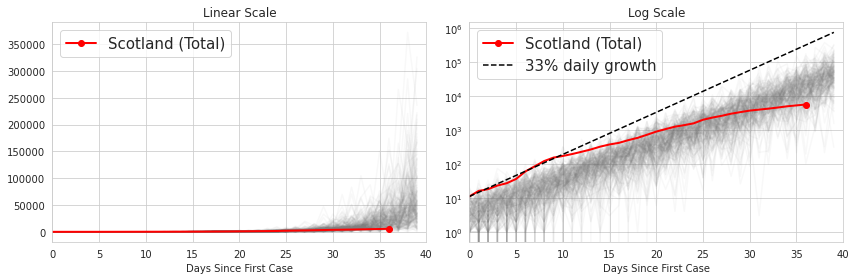

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4.0))
r = 'Scotland (Total)'
y = df_cases[r].iloc[:].values

ax = axes[0]
for sim in post_pred[r]:
    ax.plot(sim, color='gray', alpha=0.05)
ax.plot(y, marker='o', markevery=[len(y)-1],
        color='red', linewidth=2, label=r)
#ax.plot(y[0] * 1.33 ** np.arange(0, 40), label='33% daily growth', color='black', linestyle='--')
ax.set_xlim(0, 40)
ax.set_xlabel('Days Since First Case')
ax.set_title('Linear Scale')
ax.legend(fontsize=15)

ax = axes[1]
for sim in post_pred[r]:
    ax.semilogy(sim, color='gray', alpha=0.05)
ax.semilogy(y, marker='o', markevery=[len(y)-1],
        color='red', linewidth=2, label=r)
ax.semilogy(y[0] * 1.33 ** np.arange(0, 40), label='33% daily growth', color='black', linestyle='--')
ax.set_xlim(0, 40)
ax.set_xlabel('Days Since First Case')
ax.set_title('Log Scale')
ax.legend(fontsize=15)

plt.tight_layout()
plt.show()

In [32]:
pm.stats.summary(trace_scotland)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
b,28.796,4.182,20.773,36.252,0.104,0.074,1619.0,1591.0,1615.0,1706.0,1.01
a,1.275,0.019,1.242,1.313,0.000,0.000,1732.0,1730.0,1743.0,1751.0,1.00
sigma,1.676,0.533,0.762,2.664,0.014,0.010,1423.0,1423.0,1343.0,1780.0,1.00


### Create the Model

In [33]:
with pm.Model() as model:
    
    ### Intercepts ###
    # Group mean
    intr_grp = pm.Normal('intr_grp', 4.3, 2.0)
    # Group variance
    intr_grp_sigma = pm.HalfCauchy('intr_grp_sigma', 2.0)
    
    # Individual intercepts
    intr_ind = pm.Normal('intr_ind',
                          mu=intr_grp,
                          sigma=intr_grp_sigma,
                          shape=n_regions)
    
    
    ### Slopes ###
    # Group mean
    slope_grp = pm.Normal('slope_grp', 1.14, 0.5)
    # Group variance
    slope_grp_sigma = pm.HalfCauchy('slope_grp_sigma', 0.5)
    
    # Individual slopes
    slope_ind = pm.Normal('slope_ind',
                          mu=slope_grp,
                          sigma=slope_grp_sigma,
                          shape=n_regions)
    
    ### Individual Error ###
    sigma = pm.HalfCauchy('sigma', 50., shape=n_regions)
    
    ### Likelihood for Each Region ###
    for i, region in enumerate(regions):
        starting_day = starting_days[region]
        cases_region = df_cases[region].values[starting_day:]
        
        # From Twieki:
        # By using pm.Data we can change these values after sampling.
        # This allows us to extend x into the future so we can get
        # forecasts by sampling from the posterior predictive
        x = pm.Data(region + 'x_data',
                    np.arange(starting_day, max_num_days, 1))
        confirmed = pm.Data(region + 'y_data',
                            cases_region)
        
        # Likelihood
        pm.NegativeBinomial(
            region,
            (intr_ind[i] * slope_ind[i] ** x), # Exponential regression
            sigma[i],
            observed=confirmed)

In [34]:
## non-centered version
with pm.Model() as model_nc:
    
    ### Intercepts ###
    # Group mean
    intr_grp = pm.Normal('intr_grp', 4.3, 2.0)
    # Group variance
    intr_grp_sigma = pm.HalfCauchy('intr_grp_sigma', 2.0)
    
    # Individual intercepts
    #intr_ind = pm.Normal('intr_ind',
    #                      mu=intr_grp,
    #                      sigma=intr_grp_sigma,
    #                      shape=n_regions)
    intr_ind_offset = pm.Normal('intr_ind_offset', 
                                mu=0, 
                                sd=1,
                                shape=n_regions)
   
    intr_ind = pm.Deterministic('intr_ind',
                                intr_grp + intr_ind_offset * intr_grp_sigma)
    
    ### Slopes ###
    # Group mean
    slope_grp = pm.Normal('slope_grp', 1.15, 0.1)
    
    # Group variance
    slope_grp_sigma = pm.HalfCauchy('slope_grp_sigma', 0.1)
    
    # Individual slopes
    #slope_ind = pm.Normal('slope_ind',
    #                      mu=slope_grp,
    #                      sigma=slope_grp_sigma,
    #                      shape=n_regions)
    slope_ind_offset = pm.Normal('slope_ind_offset',
                                 mu=0, 
                                 sd=1,
                                 shape=n_regions)
    
    slope_ind = pm.Deterministic('slope_ind',
                                 slope_grp + slope_ind_offset * slope_grp_sigma)
    
    ### Individual Error ###
    sigma = pm.HalfCauchy('sigma', 50., shape=n_regions)
    
    ### Likelihood for Each Region ###
    for i, region in enumerate(regions):
        cases_region = df_cases[region].values[starting_days[region]:]
        
        # From Twieki:
        # By using pm.Data we can change these values after sampling.
        # This allows us to extend x into the future so we can get
        # forecasts by sampling from the posterior predictive
        x = pm.Data(region + 'x_data',
                    np.arange(0, max_num_days-starting_days[region], 1))
        confirmed = pm.Data(region + 'y_data',
                            cases_region)
        
        # Likelihood
        pm.NegativeBinomial(
            region,
            (intr_ind[i] * slope_ind[i] ** x), # Exponential regression
            sigma[i],
            observed=confirmed)

In [35]:
with model:
    # Sample posterior
    trace = pm.sample(tune=500, draws=1500, 
                      chains=2, cores=4, target_accept=0.9,
                     )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, slope_ind, slope_grp_sigma, slope_grp, intr_ind, intr_grp_sigma, intr_grp]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [06:05<00:00, 10.95draws/s]


In [36]:
import pickle

In [37]:
pickle.dump(trace, open('trace_1104.pk', 'wb'))
#pickle.dump(model, open('pymc_model_0904.pk', 'wb'))

In [38]:
with model:
    # Update data so that we get predictions into the future
    for i, r in enumerate(regions):
        #cases_region = df_cases[r].values[starting_days[r]:]
        x_data = np.arange(0, 40)
        y_data = np.array([np.nan] * len(x_data))
        pm.set_data({r + 'x_data': x_data})
        pm.set_data({r + 'y_data': y_data})
        
    # sample posterior predictive
    post_pred = pm.sample_posterior_predictive(trace, samples=200)

/home/james/local/anaconda3/envs/py36/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:58<00:00,  3.43it/s]


## Predicted Cases By Region

In [39]:
region_loc = {r: i for i,r in enumerate(regions)}

In [40]:
region_loc

{'Ayrshire and Arran': 0,
 'Borders': 1,
 'Dumfries and Galloway': 2,
 'Fife': 3,
 'Forth Valley': 4,
 'Grampian': 5,
 'Greater Glasgow and Clyde': 6,
 'Highland': 7,
 'Lanarkshire': 8,
 'Lothian': 9,
 'Shetland': 10,
 'Tayside': 11}

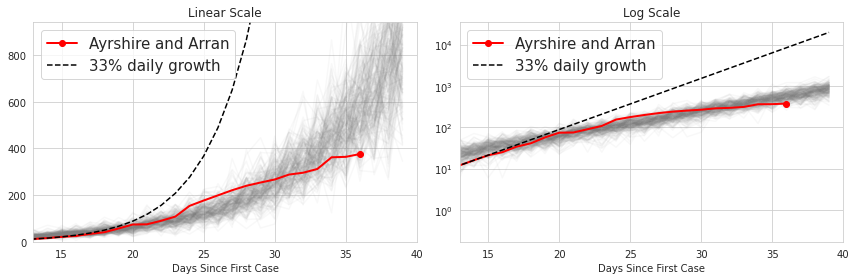

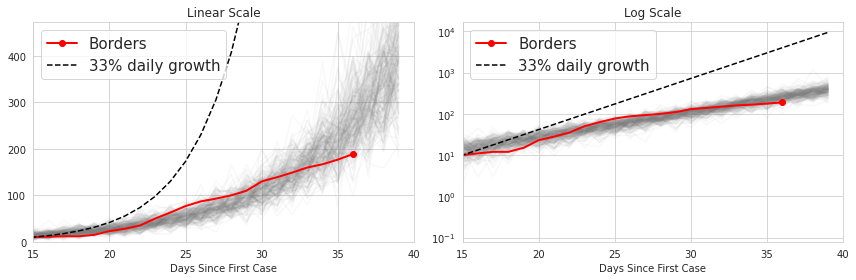

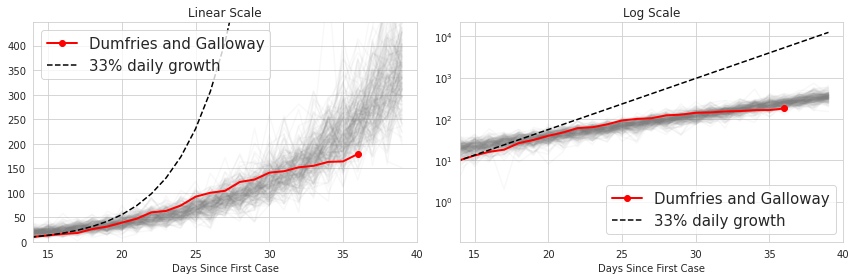

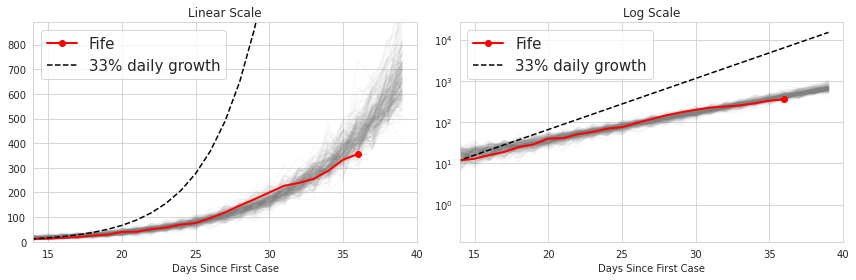

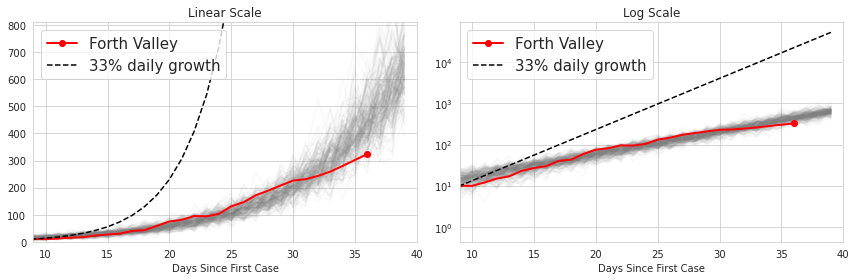

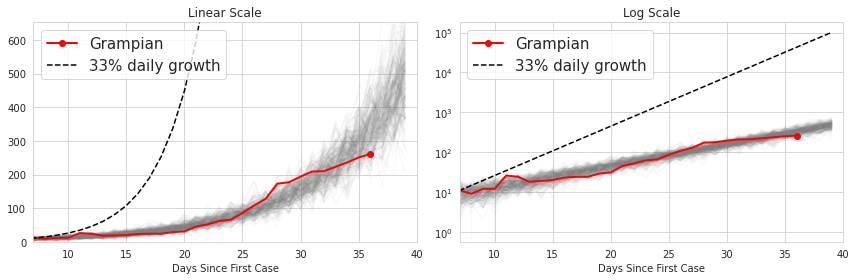

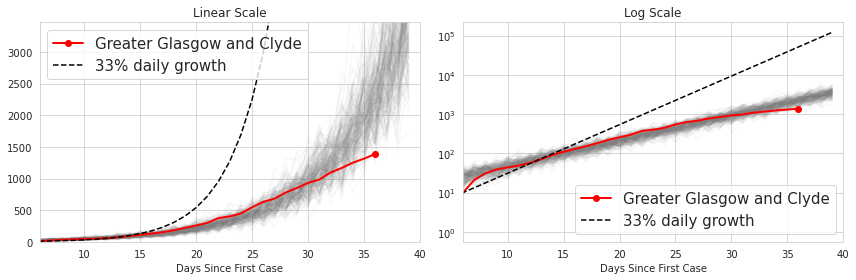

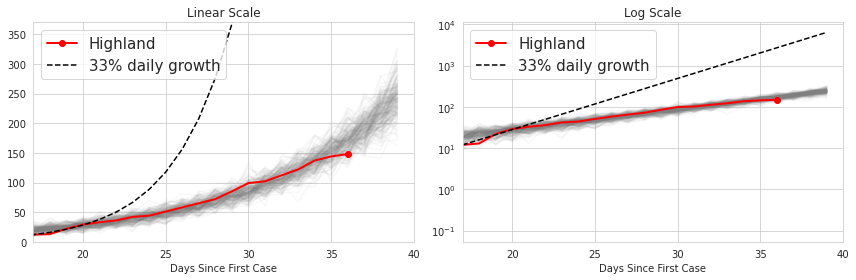

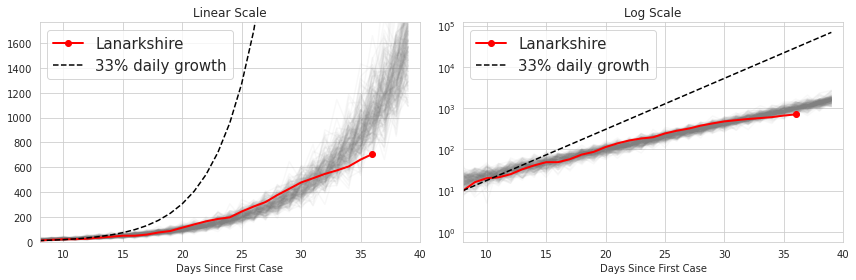

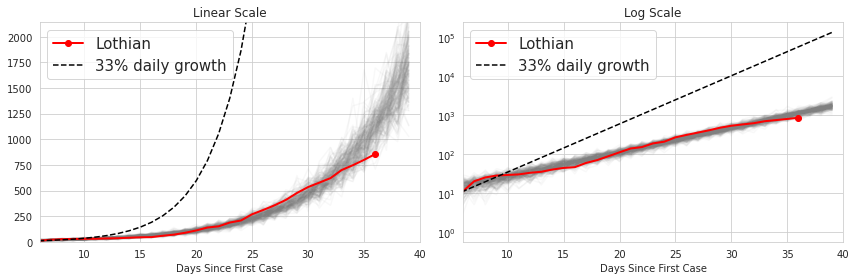

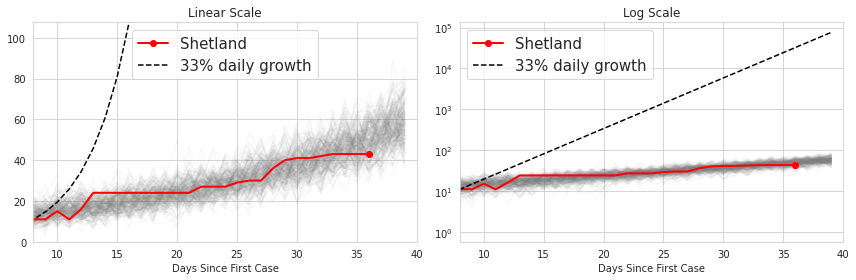

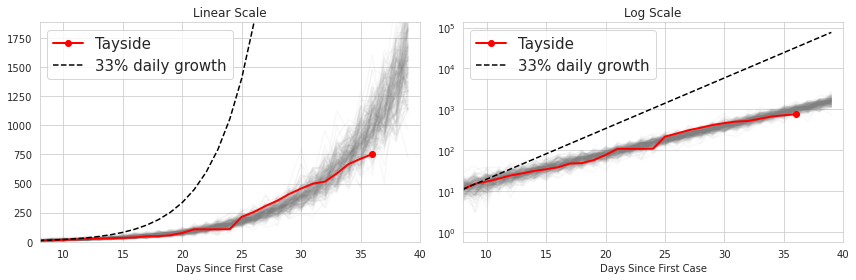

In [41]:
for r in regions:
    y = df_cases[r].iloc[:].values
    start = starting_days[r]

    fig, axes = plt.subplots(1, 2, figsize=(12, 4.0))

    ax = axes[0]
    for sim in post_pred[r]:
        ax.plot(sim, color='gray', alpha=0.05)
    ax.plot(y, marker='o', markevery=[len(y)-1],
            color='red', linewidth=2, label=r)
    ax.plot(y[start] * 1.33 ** (np.arange(0, 40)-start), label='33% daily growth', color='black', linestyle='--')
    ax.set_xlim(start, 40)
    ax.set_ylim(0, 2.5*max(y))
    ax.set_xlabel('Days Since First Case')
    ax.set_title('Linear Scale')
    ax.legend(fontsize=15)

    ax = axes[1]
    for sim in post_pred[r]:
        ax.semilogy(sim, color='gray', alpha=0.05)
    ax.semilogy(y, marker='o', markevery=[len(y)-1],
            color='red', linewidth=2, label=r)
    ax.semilogy(y[start] * 1.33 ** (np.arange(0, 40)-start), label='33% daily growth', color='black', linestyle='--')
    ax.set_xlim(start, 40)
    ax.set_xlabel('Days Since First Case')
    ax.set_title('Log Scale')
    ax.legend(fontsize=15)
    
    plt.tight_layout()
    plt.show()
    

## Posterior Growth Rates Per Region

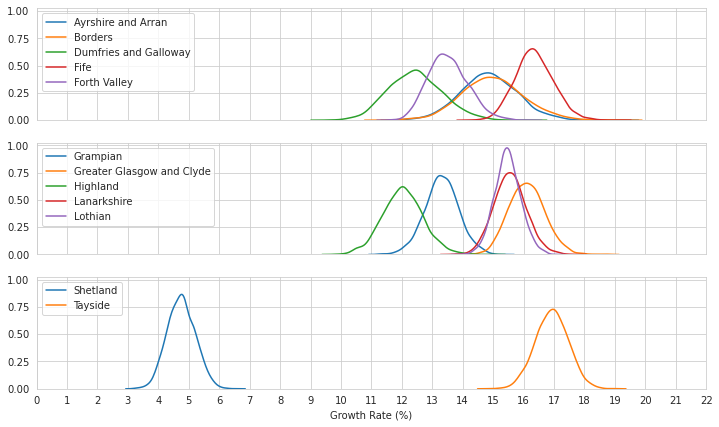

In [42]:
fig, axes = plt.subplots(3, 1, figsize=(12, 7), sharey=True, sharex=True)

for i in range(3):
    ax = axes[i]
    ax.grid()
    for r in regions[i*5: (i+1)*5]:
        sns.distplot((trace['slope_ind'][:, region_loc[r]] * 100 - 100), label=r, hist=False, ax=ax)
        ax.legend(loc=2)
        ax.grid()
    
ax.set_xlabel('Growth Rate (%)') 
ax.set_xticks(np.arange(0, 30))
ax.set_xlim(0, 22)
ax.grid()
plt.show()

Confidence intervals of growth rates for each region.

(Orkney and Western Isles ommitted due to lack of data)

In [43]:
for r in regions:
    print(f"{r} : \t{np.mean(trace['slope_ind'][:, region_loc[r]]):.6}  {pm.stats.hpd(trace['slope_ind'][:, region_loc[r]])}")

Ayrshire and Arran : 	1.14876  [1.13063768 1.16624   ]
Borders : 	1.14992  [1.13188141 1.17016253]
Dumfries and Galloway : 	1.12448  [1.10823995 1.14083969]
Fife : 	1.16357  [1.15145552 1.17466448]
Forth Valley : 	1.1352  [1.12336212 1.14715158]
Grampian : 	1.13312  [1.12246591 1.1438573 ]
Greater Glasgow and Clyde : 	1.16114  [1.15045566 1.17220568]
Highland : 	1.12037  [1.10861612 1.13369005]
Lanarkshire : 	1.15563  [1.14509649 1.16516705]
Lothian : 	1.15479  [1.14658478 1.1629625 ]
Shetland : 	1.04755  [1.0391128  1.05605573]
Tayside : 	1.1693  [1.15841019 1.1785274 ]


In [44]:
pm.stats.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
intr_grp,4.775,0.850,3.243,6.456,0.013,0.009,4559.0,4497.0,4572.0,1994.0,1.00
intr_ind[0],4.031,0.861,2.480,5.705,0.016,0.012,2830.0,2574.0,3007.0,2215.0,1.01
intr_ind[1],1.751,0.432,0.977,2.553,0.008,0.006,2885.0,2533.0,3140.0,1876.0,1.00
intr_ind[2],3.751,0.786,2.382,5.208,0.014,0.010,3161.0,2930.0,3176.0,2194.0,1.00
intr_ind[3],1.835,0.281,1.331,2.359,0.005,0.004,3104.0,2956.0,3153.0,2241.0,1.00
intr_ind[4],4.645,0.672,3.441,5.939,0.011,0.008,3928.0,3895.0,3908.0,2324.0,1.00
intr_ind[5],3.766,0.489,2.876,4.724,0.008,0.006,3423.0,3134.0,3669.0,2186.0,1.00
intr_ind[6],10.668,1.255,8.522,13.089,0.021,0.015,3547.0,3547.0,3490.0,2382.0,1.00
intr_ind[7],2.911,0.516,1.949,3.851,0.008,0.006,4372.0,3875.0,4638.0,2048.0,1.00
intr_ind[8],5.619,0.651,4.431,6.858,0.011,0.008,3364.0,3359.0,3333.0,2244.0,1.00


## Model Diagnostics

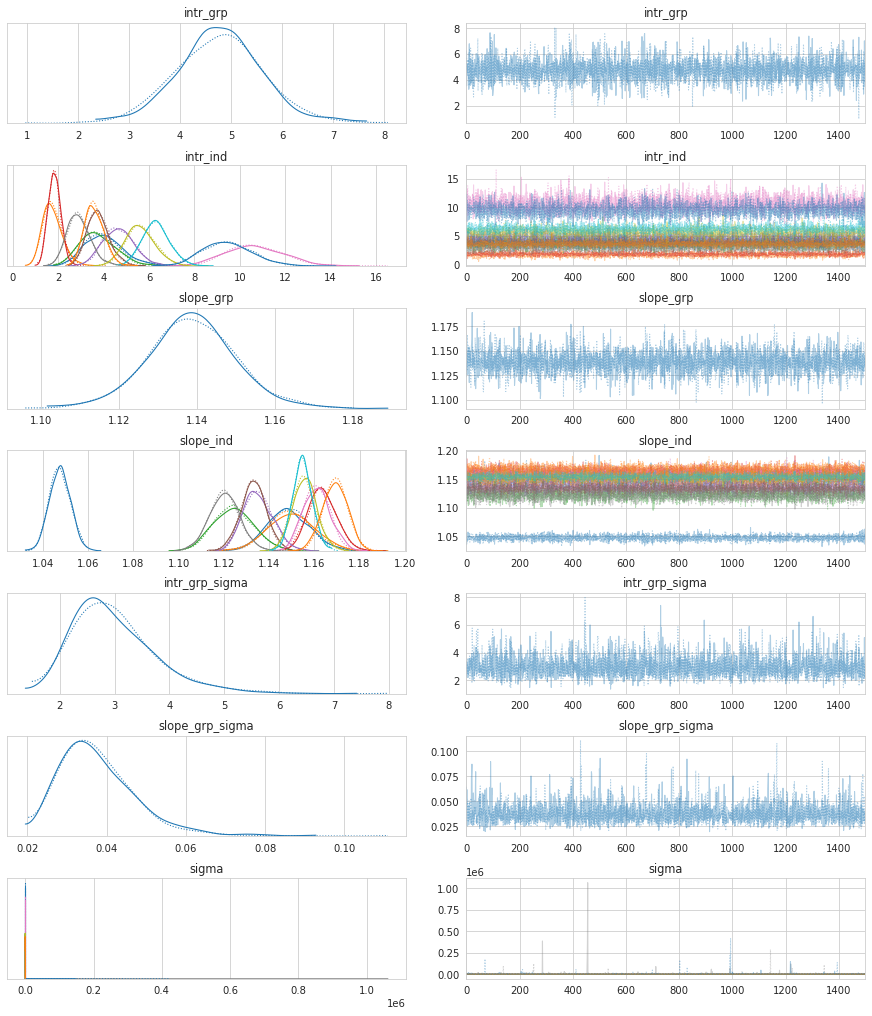

In [45]:
az.plot_trace(trace, compact=True);

In [29]:
19116 + 3000 * 20

79116